In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

sys.path.append("..")

from utils.mva_utils import (
    Ztt_inc_run3, ttV_run3, VV_run3, Top_run3, W_run3, Zll_inc_run3, ggH_run3, VBFH_run3, WH_run3, ZH_run3, ttH_run3,
    calc_vars, fetch_weights, read_root, read_data_root, save_raw_data,
    apply_cuts, combine_mc_years, combine_data_years,
    Var, Data_Var, event_cleaning, get_config, ff_scale
)

cfg_run3 = get_config('run3')

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------------
# Build weights per dataset/process
# -----------------------------

datasets = ['mc23a', 'mc23d', 'mc23e']

categories = {
    'signal': {'VBFH': VBFH_run3, 'ggH': ggH_run3, 'WH': WH_run3, 'ZH': ZH_run3, 'ttH': ttH_run3},
    'background': {'Ztt_inc': Ztt_inc_run3, 'VV': VV_run3, 'Top': Top_run3, 'W': W_run3, 'Zll_inc': Zll_inc_run3, 'ttV': ttV_run3}
}

weights = {}
for dataset in datasets:
    weights[dataset] = {}
    for category, processes in categories.items():
        weights[dataset][category] = {}
        for process_name, process_list in processes.items():
            key = f"{process_name}_ws_{dataset[-1]}"
            print(f"\nProcessing {process_name} for {dataset}...")
            weights[dataset][category][key] = fetch_weights(process_list, dataset)


Processing VBFH for mc23a...
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 603422, year: mc23a, weight: 0.05048950954, sum: 50058121.76775932
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 603423, year: mc23a, weight: 0.01739184846, sum: 24560735.503458977
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 603424, year: mc23a, weight: 0.020462623080000002, sum: 24985585.3717494
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 603425, year: mc23a, weight: 0.01476969442, sum: 49760343.502305984
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 601599, year: mc23a, weight: 0.0471568398113343, sum: 5925337.189682007

Processing ggH for mc23a...
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 603414, year: mc23a, weight: 0.61191944, sum: 200001123.0151981
Reading weights from ../data/xsec_sumofweights_nom_run3.json
DSID 603415, year: mc23a, weight: 0.24496432399999998, sum: 72692784.981

In [3]:
# -----------------------------
# Read MC and Data
# -----------------------------

processes = {
    'signal': {'VBFH': VBFH_run3, 'ggH': ggH_run3, 'WH': WH_run3, 'ZH': ZH_run3, 'ttH': ttH_run3},
    'background': {'Ztt_inc': Ztt_inc_run3, 'VV': VV_run3, 'Top': Top_run3, 'W': W_run3, 'Zll_inc': Zll_inc_run3, 'ttV': ttV_run3}
}

total_mc = {}
for dataset in ['mc23a', 'mc23d', 'mc23e']:
    suffix = dataset[-1]
    year = cfg_run3['year_map'][dataset]
    dataset_results = {}
    for category, procs in processes.items():
        for proc_name, proc_list in procs.items():
            weight_key = f"{proc_name}_ws_{suffix}"
            weight = weights[dataset][category][weight_key]
            var_name = f"{proc_name}_{suffix}"
            dataset_results[var_name] = read_root(proc_list, weight, year_id=dataset, year=year, is_signal=(category == 'signal'), config=cfg_run3)
    total_mc[dataset] = dataset_results


data_22 = read_data_root(year='22', config=cfg_run3)
data_23 = read_data_root(year='23', config=cfg_run3)
data_24 = read_data_root(year='24', config=cfg_run3)

# Save raw
save_raw_data(total_mc, 'MC')
save_raw_data({'data_22': data_22, 'data_23': data_23, 'data_24': data_24}, 'data')

{'data_22': <Array [{event_number: 807136162, ...}, ...] type='409189 * {event_number: ...'>,
 'data_23': <Array [{event_number: 1909624435, ...}, ...] type='443962 * {event_number:...'>,
 'data_24': <Array [{event_number: 3505957443, ...}, ...] type='2712184 * {event_number...'>}

In [2]:
# -----------------------------
# Apply cuts and combine years
# -----------------------------

with open('/global/homes/a/agarabag/pscratch/ditdau_samples/raw_mc_data_test_run3.pkl', 'rb') as f:
    uncut_mc = pickle.load(f)
with open('/global/homes/a/agarabag/pscratch/ditdau_samples/raw_data_data_test_run3.pkl', 'rb') as f:
    uncut_data = pickle.load(f)

cut_data = apply_cuts({'data_22': uncut_data['data_22'], 'data_23': uncut_data['data_23'], 'data_24': uncut_data['data_24']}, data_type='data', config=cfg_run3)

cut_mc = apply_cuts(uncut_mc, data_type='MC', config=cfg_run3)

combined_mc = combine_mc_years(cut_mc)
combines_data = combine_data_years(cut_data)

In [3]:
# -----------------------------
# Build variables and DataFrames
# -----------------------------

vbfh_cut = combined_mc['VBFH']
ggh_cut = combined_mc['ggH']
wh_cut = combined_mc['WH']
zh_cut = combined_mc['ZH']
tth_cut = combined_mc['ttH']
ztt_inc_cut = combined_mc['Ztt_inc']
ttv_cut = combined_mc['ttV']
vv_cut = combined_mc['VV']
top_cut = combined_mc['Top']
w_cut = combined_mc['W']
zll_inc_cut = combined_mc['Zll_inc']

data_cut = combines_data

ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)
vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_inc_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_inc_cut)

ggh_plot = event_cleaning(ggh_plot)
vbfh_plot = event_cleaning(vbfh_plot)
wh_plot = event_cleaning(wh_plot)
zh_plot = event_cleaning(zh_plot)
tth_plot = event_cleaning(tth_plot)
vv_plot = event_cleaning(vv_plot)
top_plot = event_cleaning(top_plot)
ztt_plot = event_cleaning(ztt_plot)
ttv_plot = event_cleaning(ttv_plot)
w_plot = event_cleaning(w_plot)
zll_plot = event_cleaning(zll_plot)

ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)
vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)

data_plot = Data_Var(data_cut, config=cfg_run3)
data_plot = event_cleaning(data_plot)
data_plot = pd.DataFrame(np.array(data_plot).T, columns=calc_vars)

In [4]:
# -----------------------------
# Labeling and concatenation
# -----------------------------

for df_, label in [(vbfh_plot, 1), (ggh_plot, 1), (wh_plot, 1), (zh_plot, 1), (tth_plot, 1),
                   (vv_plot, 0), (top_plot, 0), (ztt_plot, 0), (ttv_plot, 0) , (w_plot, 0), (zll_plot, 0), (data_plot, 0)]:
    df_['label'] = label

vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'
vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

df = pd.concat([vbfh_plot, ggh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot, data_plot])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass', 'delta_R', 'delta_phi',
    'delta_eta', 'label', 'met', 'met_sig', 'met_centrality', 'event_number', 'fake_factor', 'combined_weights', 'k_t',
    'x1', 'x2', 'sample_type', 'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
    'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
    'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
    'delta_phi_met_ditau'
]

df = df[training_var]

In [5]:
print('VBFH:', len(vbfh_plot))
print('GGH:', len(ggh_plot))
print('WH:', len(wh_plot))
print('ZH:', len(zh_plot))
print('TTH:', len(tth_plot))
print('VV:', len(vv_plot))
print('TOP:', len(top_plot))
print('ZTT:', len(ztt_plot))
print('TTV:', len(ttv_plot))
print('W:', len(w_plot))
print('ZLL:', len(zll_plot))
print('Data:', len(data_plot))

VBFH: 48527
GGH: 9814
WH: 6368
ZH: 5503
TTH: 1852
VV: 100043
TOP: 111
ZTT: 373805
TTV: 649
W: 183
ZLL: 24272
Data: 25197


In [6]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    524260
1     72064
Name: count, dtype: int64

In [7]:
print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
print(df.loc[df['fake_factor'] < 0, 'fake_factor'])

Series([], Name: combined_weights, dtype: float64)
Series([], Name: fake_factor, dtype: float64)


In [8]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [9]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 199178 198469 198677 0 0
Signal Split: 23993 24023 24048 0 0


Background Split: 175185 174446 174629 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'omni_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt',
       'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
       'delta_phi_met_ditau', 'ids'],
      dtype='object')


len X_train: 397146
len X_test: 199178
signal scaling factor:  7.261654635851137
len X_train: 397855
len X_test: 198469
signal scaling factor:  7.28157199059137
len X_train: 397647
len X_test: 198677
signal scaling factor:  7.281551982672442


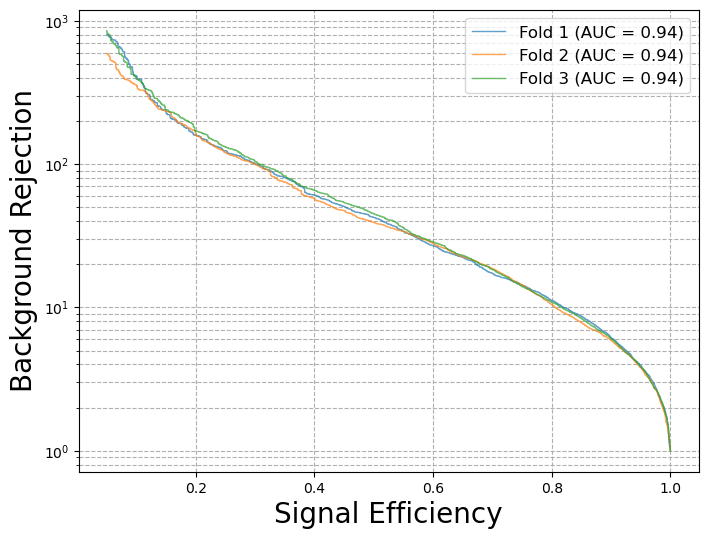

In [10]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

all_shap_values = []
all_feature_names = []

bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
    'delta_phi_met_ditau': 'f10',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    training_weight = ff_train*evnt_w_train
    val_weights = ff_test*evnt_w_test

    # training_weight = ff_train
    # val_weights = ff_test

    # training_weight = np.ones(len(y_train))
    # val_weights = np.ones(len(y_test))

    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }

    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    # Reverse the feature_name_mapping
    reversed_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
    X_test_renamed = X_test.rename(columns=reversed_feature_name_mapping)
    all_feature_names.append(X_test_renamed.columns)
    # all_feature_names.append(X_test.columns)

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



In [11]:
print(X_train.columns.tolist(), X_train.dtypes, y_train.dtype, training_weight.dtype)

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'] f0     float64
f1     float64
f2     float64
f3     float64
f4     float64
f5     float64
f6     float64
f7     float64
f8     float64
f9     float64
f10    float64
dtype: object int64 float64


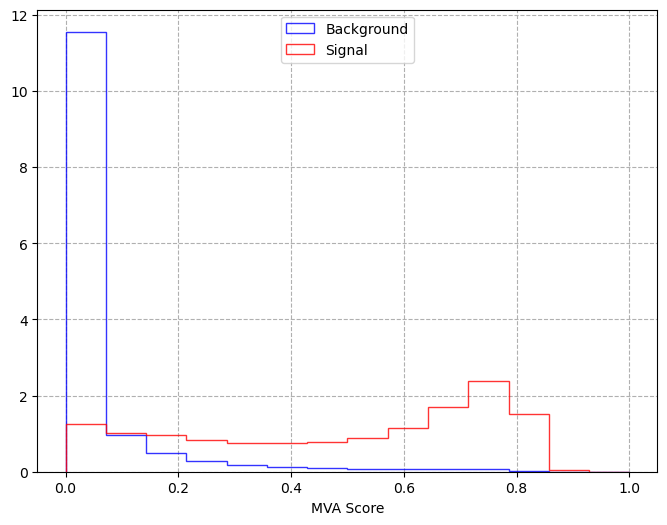

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
# Aggregate SHAP values across all folds
mean_shap_values = np.mean([np.abs(shap_values).mean(0) for shap_values in all_shap_values], axis=0)
feature_names = all_feature_names[0]  # Assuming feature names are consistent across folds

# Sort features by importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap_values})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
shap.summary_plot(all_shap_values[2], X_test, plot_type="bar", feature_names=feature_names)
shap.summary_plot(all_shap_values[2], X_test, feature_names=feature_names)

# Print feature importance
print("Feature Importance Ranking:")
print(feature_importance)